In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.ndimage import gaussian_filter1d
import logging

In [6]:
# Loading data
df = pd.read_csv('/content/final_data_exchange_bias.csv')
df = df.drop(columns=['core', 'shell', 'formula'])

# Dictionary for renaming columns
rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_bias_oe': 'Exchange bias shift',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core b lattice parameter',
    'core_alpha': 'Core alpha angle',
    'core_beta': 'Core beta angle',
    'core_gamma': 'Core gamma angle',
    'shell_b': 'Shell b lattice parameter',
    'shell_alpha': 'Shell alpha angle',
    'shell_beta': 'Shell beta angle',
    'shell_gamma': 'Shell gamma angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio с to a',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

# Renaming columns
df = df.rename(columns=rename_dict)

In [7]:
# Preprocessing
y = df['Exchange bias shift']
y = y[y > 0]  # Filter only positive values
y_smooth = gaussian_filter1d(y, sigma=2)

# Log transformation of the smoothed target variable
y_log = np.log10(y_smooth)

In [8]:
# Feature selection
X = df[df['Exchange bias shift'] > 0].drop(columns=['Exchange bias shift'])

# Applying KNN Imputer to fill missing values
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)

# Convert the imputed array back into a DataFrame and ensure the renamed columns are used
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

In [9]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed_df, y_log, test_size=0.2, random_state=1984)

# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with the same column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [10]:
# Defining models with specified hyperparameters
models = {
    'LGBM': LGBMRegressor(n_estimators=410, max_depth=27, learning_rate=0.06189087491958441, num_leaves=60,
                            min_data_in_leaf=22, feature_fraction=0.5107580106941778, scale_pos_weight=19.965009642913554,
                            reg_alpha=0.061407641972931915, reg_lambda=0.5275644028683729, bagging_fraction=0.8938154558415361,
                            bagging_freq=4, random_state=1984, verbose=-1),
    'RandomForest': RandomForestRegressor(n_estimators=384, max_depth=65, min_samples_split=3,
                                             min_samples_leaf=2, bootstrap=False, max_features='log2', random_state=1984),
    'XGB': XGBRegressor(n_estimators=424, max_depth=22, learning_rate=0.029775486467142665,
                           subsample=0.7358573421632647, colsample_bytree=0.5128835927539236, gamma=0.001178216687382395,
                           reg_alpha=0.3688362981967942, reg_lambda=0.9581849266893232, min_child_weight=4,
                           scale_pos_weight=9.787498596663324, random_state=1984),
}

In [11]:
# Training models and generating SHAP plots
shap_values = {}
explainer = {}

Training LGBM...


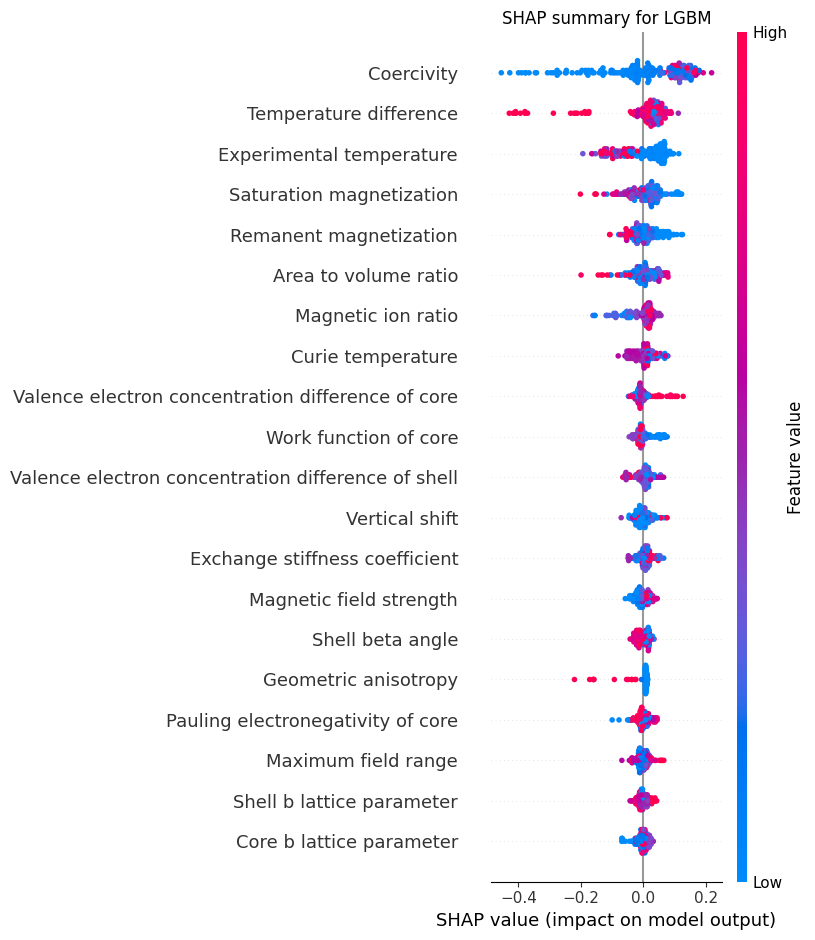

Training RandomForest...


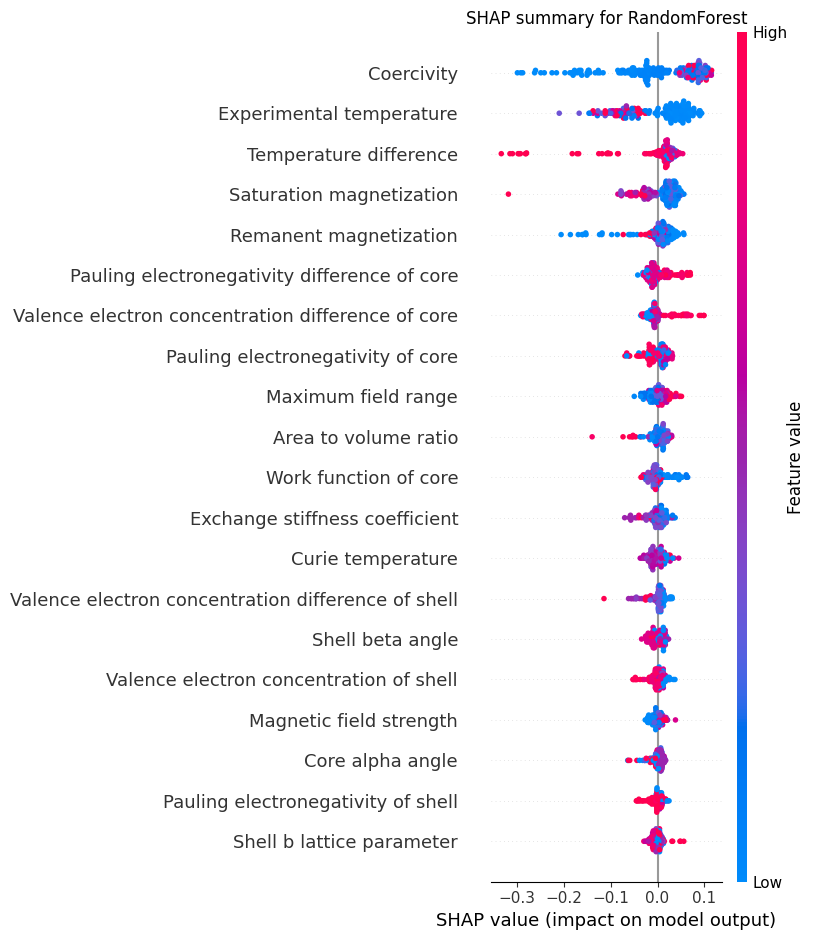

Training XGB...


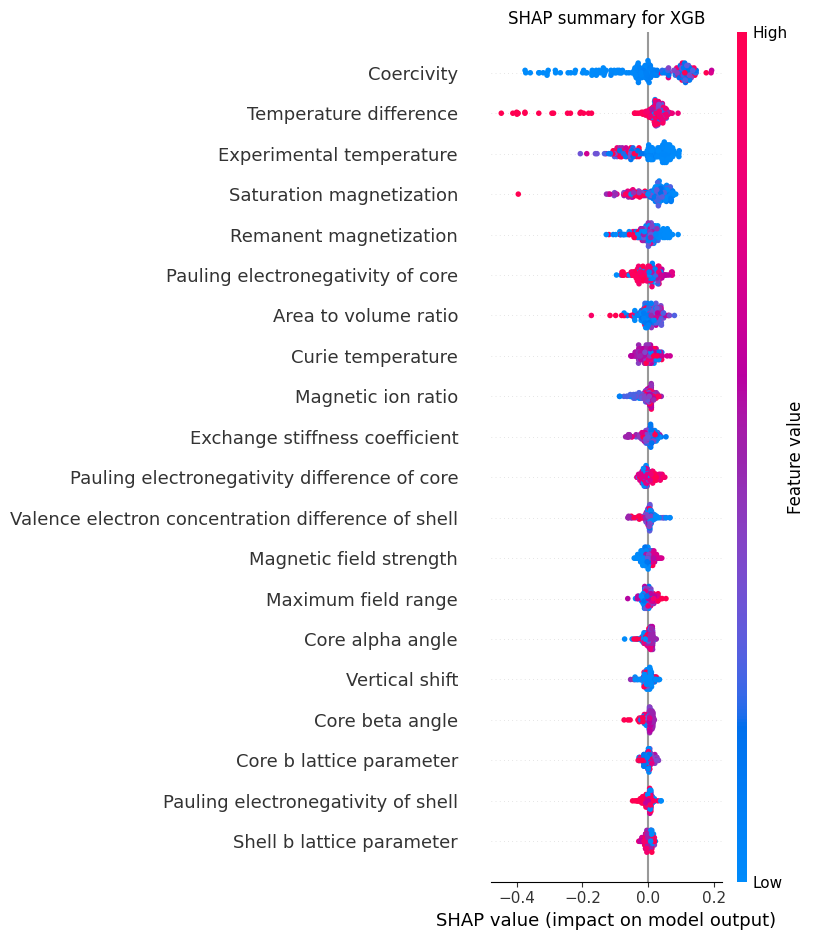

In [12]:
for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train_scaled_df, y_train)

    # Using TreeExplainer for tree-based models
    if name.startswith(('ExtraTrees', 'RandomForest', 'GradientBoosting', 'HistGradientBoosting', 'XGB', 'LGBM')):
        explainer[name] = shap.TreeExplainer(model)
        shap_values[name] = explainer[name].shap_values(X_test_scaled_df)
    else:
        # Using KernelExplainer for Bagging Regressor
        explainer[name] = shap.KernelExplainer(model.predict, X_train_scaled_df[:50])  # Use a small sample for speed
        shap_values[name] = explainer[name].shap_values(X_test_scaled_df)

    # Plot SHAP summary for top 6 most important features
    plt.title(f'SHAP summary for {name}')
    shap.summary_plot(shap_values[name], X_test_scaled_df)
    plt.show()